## SAE IA et occulométrie - Selma EL BABARTI & Christelle RAVONJIARIVELO 

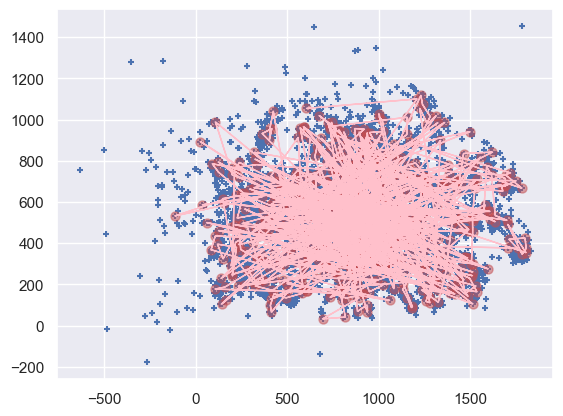

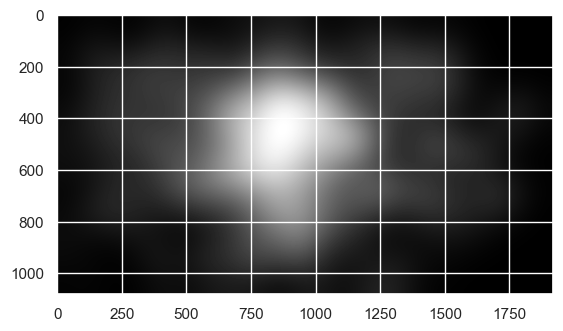

In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import random
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import FixationSaccadeRepresentation
from FixationSaccadeRepresentation import *
import SaliencyMap
from SaliencyMap import * 

In [107]:
plt.rcParams["axes.grid"] = False

Ce travail est divisé en trois parties :
- La phase exploratoire
- La phase de manipulation (création de features ,....)
- La phase d'apprentissage 

<span style="color:red;">Ce notebook est à éxécuter dans le répértoire avec les données.<br>
***Des nouveaux dossiers et des fichiers seront créés.*** </span>


# PARTIE 1- EXPLORATION

Dans le cadre de la SAE Intelligence artificielle, nous allons utiliser des données d'eye-tracking obtenus sur 24 participants réalisant 8 activités différentes sur ordinateur : Lire, Naviguer, Jouer, Rechercher, Regarder, Ecrire, Déboguer et Interpréter (du code).

#### Les points à savoir : 
Toutes les activités duraient envrion 5 minutes. 

Les mouvements des yeux ont enregistrés à l'aide d'un oculomètre Tobii X23-30 et du logiciel Tobii Pro Studio. 

Nous disposions de variables de fixations et de saccades qui sont calculées pour chaque observateur (obs) et chaque stimuli (im). Les variables sont : 
- la durée de chaque fixation (Fix_Duration)
- la position en X de chaque fixation en pixels (FixPosX)
- la position en Y de chaque fixation en pixels (FixPosY)
- l'amplitude en pixels de chaque saccade (Saccade_Amp)
- l'angle absolu en degré de chaque saccade (Saccade_AbsAng) 
- l'angle relatif en degré de chaque saccade (Saccade_RelAng)


Le but de ce travail est d'utiliser ces données afin de les explorer et nous poser une interrogation à laquelle nous tenterons d'apporter une réponse grâce à un apprentissage supervisé et un apprentissage non supervisé.

<span style="color:blue;"> Tout d'abord, explorons les données en effectuant quelques historgramme afin d'en savoir plus sur les dispersions : </span>


In [108]:
# Liste des activités
activities = ["BROWSE", "DEBUG", "INTERPRET", "PLAY", "READ", "SEARCH", "WATCH", "WRITE"]
# Liste des participants sous la forme P01 à P24
participants = ["P{:02d}".format(i+1) for i in range(24)]

Ce code définit une liste d'activités comprenant les actions "BROWSE", "DEBUG", "INTERPRET", "PLAY", "READ", "SEARCH", "WATCH" et "WRITE". Il crée également une liste de participants numérotés de "P01" à "P24" en utilisant une boucle for et le formatage de chaîne de caractères.

### Nombre de points de fixations par activités

Nous allons analyser les données de fixation pour différentes activités sans utiliser les données normalisées sur le temps des tâches. Le code parcourt chaque participant et chaque activité, stocke le nombre total de fixations pour chaque activité et trace un histogramme des fréquences des activités pour visualiser les résultats.

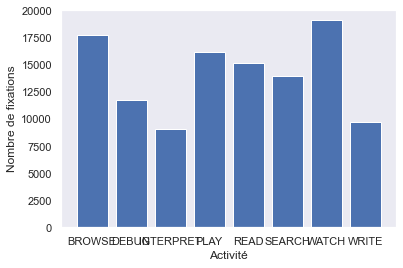

In [109]:
#SANS NORMALISATION SUR LE TEMPS DES TACHES

# Initialisation du dictionnaire pour stocker les données de fixation
fixation_data = {}

# Boucle sur chaque participant et chaque activité
for participant in range(1,25):
    for activity in activities:
        # Nom du fichier
        file_name = f"Fixations_Features/P{participant:02d}_{activity}.csv"
        
        # Chargement des données de fixation
        data = pd.read_csv(file_name)
        
        # Calcul du nombre total de fixations
        num_fixations = data.shape[0]
        
        # Stockage des données de fixation pour l'activité courante
        if activity in fixation_data:
            fixation_data[activity] += num_fixations
        else:
            fixation_data[activity] = num_fixations

# Tracé de l'histogramme des fréquences des activités
plt.bar(range(len(fixation_data)), list(fixation_data.values()), align='center')
plt.xticks(range(len(fixation_data)), list(fixation_data.keys()))
plt.xlabel("Activité")
plt.ylabel("Nombre de fixations")
plt.show()

Nous allons maintenant faire pareil avec les donnnées normalisées.

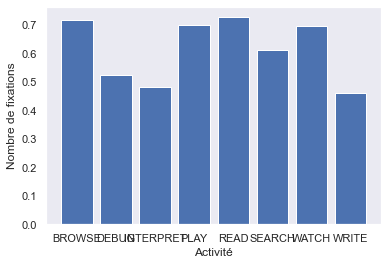

In [110]:
#AVEC NORMALISATION SUR LE TEMPS TOTAL DE LA TACHE

# Initialisation du dictionnaire pour stocker les données de fixation
fixation_data = {}

# Boucle sur chaque participant et chaque activité
for participant in range(1,25):
    for activity in activities:
        # Nom du fichier
        file_name = f"dataset_normalised_5mins/P{participant:02d}_{activity}.csv"
        
        # Chargement des données de fixation
        data = pd.read_csv(file_name)
        
        # Calcul de la durée maximale de l'activité
        activity_duration = data['timestamp'].max()
        
        # Calcul du nombre total de fixations
        num_fixations = data.shape[0]
        
        # Stockage des données de fixation pour l'activité courante
        if activity in fixation_data:
            fixation_data[activity] += num_fixations / activity_duration
        else:
            fixation_data[activity] = num_fixations / activity_duration

# Tracé de l'histogramme des fréquences des activités
plt.bar(range(len(fixation_data)), list(fixation_data.values()), align='center')
plt.xticks(range(len(fixation_data)), list(fixation_data.keys()))
plt.xlabel("Activité")
plt.ylabel("Nombre de fixations")
plt.show()

### Les durées de fixations des participants :

#### Histogramme des durées de fixation par activité pour tous les participants

Nous allons analyser les durées de fixation pour différentes activités en récupérant les données de participants et en créant des histogrammes pour visualiser les durées de fixation. Le code parcourt chaque participant et chaque activité, extrait les durées de fixation, les stocke dans un DataFrame et crée des histogrammes pour représenter les durées de fixation par activité.

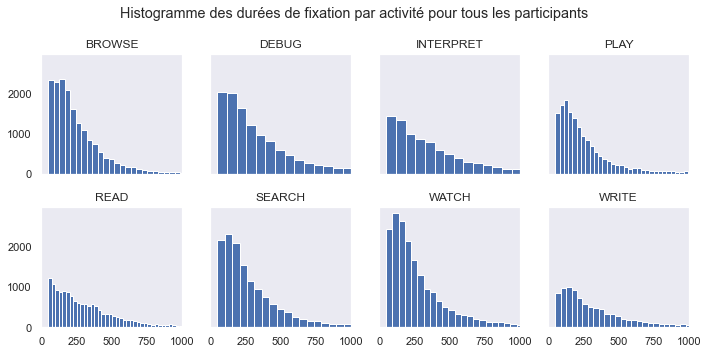

In [111]:

# Initialisation du DataFrame pour stocker les données
fixations_durations = pd.DataFrame(columns=["Participant", "Activity", "Duration"])

# Boucle sur les participants et les activités pour récupérer les durées de fixation
for participant in participants:
    for activity in activities:
        # Chargement des données pour le participant et l'activité courants
        filename = "Fixations_Features/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        # Calcul de la durée de fixation pour chaque enregistrement
        durations = data["Duration"]
        # Ajout des données au DataFrame fixations_durations
        fixations_durations = pd.concat([fixations_durations, pd.DataFrame({"Participant": [participant]*len(durations), "Activity": [activity]*len(durations), "Duration": durations})], ignore_index=True)

# Création d'un histogramme pour chaque activité
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10,5))
for i, activity in enumerate(activities):
    # Récupération des durées de fixation pour l'activité courante
    durations = fixations_durations[fixations_durations["Activity"] == activity]["Duration"]
    # Création de l'histogramme pour les durées de fixation
    axs[i//4, i%4].hist(durations, bins=200)
    axs[i//4, i%4].set_title(activity)
    axs[i//4, i%4].set_xlim([0, 1000])
plt.suptitle("Histogramme des durées de fixation par activité pour tous les participants")
plt.tight_layout()
plt.show()

#### Dispersion des durées de fixation moyennes par participant et par activité

Nous allons calculer les moyennes et les écarts-types des durées de fixation pour chaque participant et chaque activité afin d'analyser la dispersion des données. Le code regroupe les durées de fixation, calcule les moyennes et les écarts-types, puis affiche la dispersion des durées moyennes par participant pour chaque activité à l'aide de graphiques d'erreurs.

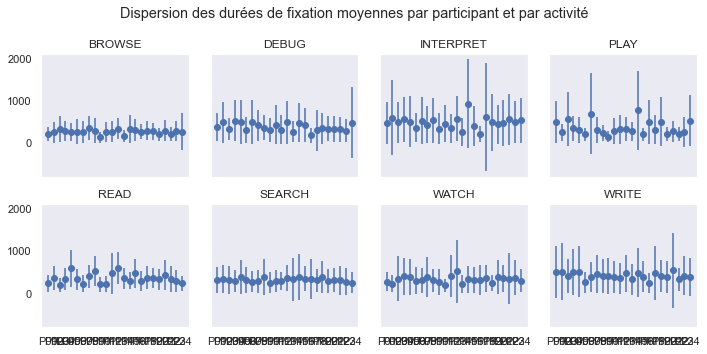

In [112]:
# Calcul des moyennes et des écarts-types par participant et par activité
means = fixations_durations.groupby(["Participant", "Activity"]).mean().reset_index()
stds = fixations_durations.groupby(["Participant", "Activity"]).std().reset_index()

# Affichage de la dispersion des moyennes par activité
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10,5))
for i, activity in enumerate(activities):
    # Récupération des moyennes et des écarts-types pour l'activité courante
    means_activity = means[means["Activity"] == activity]
    stds_activity = stds[stds["Activity"] == activity]
    # Affichage de la dispersion des moyennes par participant
    ax = axs[i // 4, i % 4]
    ax.errorbar(means_activity["Participant"], means_activity["Duration"], yerr=stds_activity["Duration"], fmt="o")
    ax.set_title(activity)
plt.suptitle("Dispersion des durées de fixation moyennes par participant et par activité")
plt.tight_layout()
plt.show()

Pour les activités INTERPRET, PLAY, WTACH et WRITE, nous remarquons des dispersions plus importantes entre les participants en comparaison au reste des activités (quelques participants se démarquent notamment des autres de part leurs durées de fixations soit très rapides, soit très lentes). 

### Les vitesses des saccades : 

#### Histogramme des vitesses de saccades par activité pour tous les participants

Nous allons collecter les données de vitesses de saccades pour chaque participant et chaque activité. En initialisant un DataFrame, nous bouclerons ensuite sur les participants et les activités pour extraire les vitesses de saccades à partir des données disponibles. En utilisant ces données, nous créerons des histogrammes des vitesses de saccades par activité pour tous les participants, permettant ainsi d'analyser les distributions des vitesses de saccades.

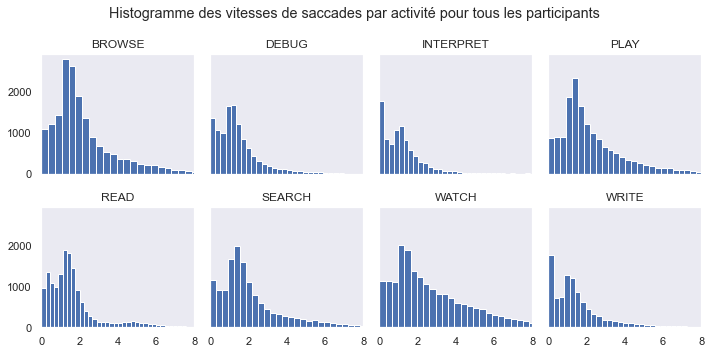

In [113]:
# Initialisation du DataFrame pour stocker les données
saccades_speeds = pd.DataFrame(columns=["Participant", "Activity", "Speed"])

# Boucle sur les participants et les activités pour récupérer les vitesses de saccades
for participant in participants:
    for activity in activities:
        # Chargement des données pour le participant et l'activité courants
        filename = "Saccades_Features/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        # Calcul de la vitesse de saccades pour chaque enregistrement
        speeds = data["Amplitude"] / data["Duration"]
        # Ajout des données au DataFrame saccades_speeds
        saccades_speeds = pd.concat([saccades_speeds, pd.DataFrame({"Participant": [participant]*len(speeds), "Activity": [activity]*len(speeds), "Speed": speeds})])

# Création de l'histogramme des vitesses de saccades par activité pour tous les participants
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10,5))
for i, activity in enumerate(activities):
    # Récupération des vitesses de saccades pour l'activité courante
    speeds = saccades_speeds[saccades_speeds["Activity"] == activity]["Speed"]
    # Création de l'histogramme pour les vitesses de saccades
    ax = axs[i // 4, i % 4]
    ax.hist(speeds, bins=50)
    ax.set_title(activity)
plt.xlim([0,8])    
plt.suptitle("Histogramme des vitesses de saccades par activité pour tous les participants")
plt.tight_layout()
plt.show()

La majorité des participants ont des vitesses de saccades assez courtes (autour de 1 à 2 degré/milliseconde) pour la plupart des activités. Cette dispartié suit plus ou moins le meme schéma pour toutes les activités même si elle parait un peu moins vraie pour les activités dont la disparité parait plus elevée (comme BROWSE, PLAY, SEARCH ou WATCH qui signifie que pour ce type d'activité, les vitesses de saccades sont plus longues).

#### Dispersion des vitesses de saccades moyennes par participant et par activité

Nous allons calculer les moyennes et les écarts-types des vitesses de saccades pour chaque participant et chaque activité. En utilisant un DataFrame contenant les données de vitesses de saccades, nous regrouperons les données par participant et par activité, puis calculerons les moyennes et les écarts-types. Ensuite, nous afficherons la dispersion des moyennes de vitesses de saccades par participant pour chaque activité à l'aide de graphiques d'erreurs, ce qui nous permettra d'analyser la variabilité des vitesses de saccades.

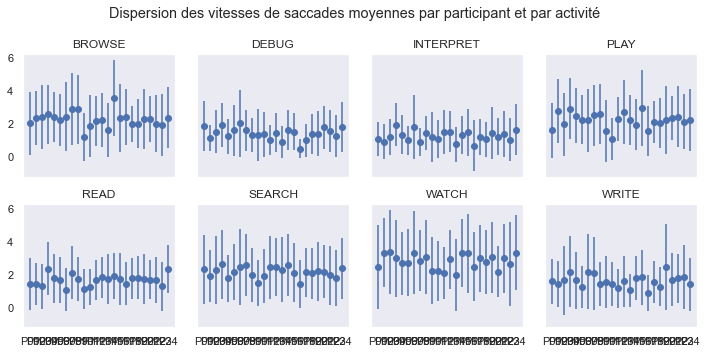

In [114]:
# Calcul des moyennes et des écarts-types par participant et par activité
means = saccades_speeds.groupby(["Participant", "Activity"]).mean().reset_index()
stds = saccades_speeds.groupby(["Participant", "Activity"]).std().reset_index()

# Affichage de la dispersion des moyennes par activité
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10,5))
for i, activity in enumerate(activities):
    # Récupération des moyennes et des écarts-types pour l'activité courante
    means_activity = means[means["Activity"] == activity]
    stds_activity = stds[stds["Activity"] == activity]
    # Affichage de la dispersion des moyennes par participant
    ax = axs[i // 4, i % 4]
    ax.errorbar(means_activity["Participant"], means_activity["Speed"], yerr=stds_activity["Speed"], fmt="o")
    ax.set_title(activity)
plt.suptitle("Dispersion des vitesses de saccades moyennes par participant et par activité")
plt.tight_layout()
plt.show()

Pour toutes les activités, la disparité est très importante selon les partiticpants.

### Les amplitudes des saccades :

#### Histogramme des amplitudes de saccades par activité pour tous les participants

Nous allons initialiser un DataFrame pour stocker les données des amplitudes de saccades des participants pendant différentes activités, puis parcourir les participants et les activités pour récupérer les amplitudes de saccades, les ajouter au DataFrame et enfin créer un histogramme des amplitudes de saccades par activité pour tous les participants.

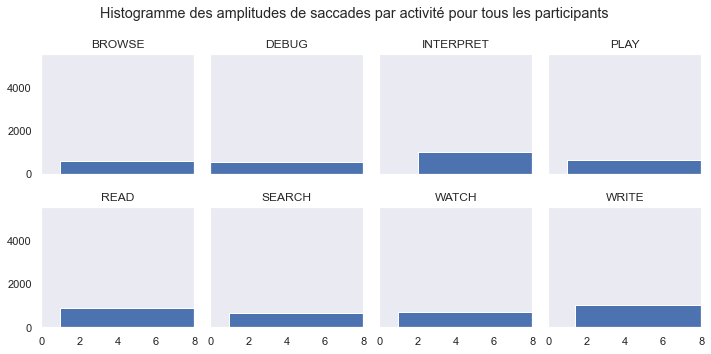

In [115]:
# Initialisation du DataFrame pour stocker les données
saccades_ampl = pd.DataFrame(columns=["Participant", "Activity", "Amplitude"])

# Boucle sur les participants et les activités pour récupérer les vitesses de saccades
for participant in participants:
    for activity in activities:
        # Chargement des données pour le participant et l'activité courants
        filename = "Saccades_Features/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        # Calcul de la vitesse de saccades pour chaque enregistrement
        amplitudes = data["Amplitude"]
        # Ajout des données au DataFrame saccades_speeds
        saccades_ampl = pd.concat([saccades_ampl, pd.DataFrame({"Participant": [participant]*len(amplitudes), "Activity": [activity]*len(amplitudes), "Amplitude": amplitudes})])

# Création de l'histogramme des vitesses de saccades par activité pour tous les participants
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10,5))
for i, activity in enumerate(activities):
    # Récupération des vitesses de saccades pour l'activité courante
    amplitudes = saccades_ampl[saccades_ampl["Activity"] == activity]["Amplitude"]
    # Création de l'histogramme pour les vitesses de saccades
    ax = axs[i // 4, i % 4]
    ax.hist(amplitudes, bins=50)
    ax.set_title(activity)
plt.xlim([0,8])    
plt.suptitle("Histogramme des amplitudes de saccades par activité pour tous les participants")
plt.tight_layout()
plt.show()

#### Dispersion des amplitudes de saccades moyennes par participant et par activité

Nous allons calculer les moyennes et les écarts-types des amplitudes de saccades par participant et par activité, puis afficher la dispersion des moyennes par activité en utilisant des barres d'erreur représentant les écarts-types.

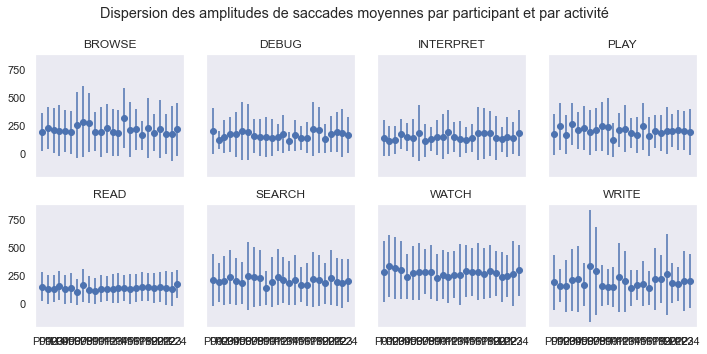

In [116]:
# Calcul des moyennes et des écarts-types par participant et par activité
means = saccades_ampl.groupby(["Participant", "Activity"]).mean().reset_index()
stds = saccades_ampl.groupby(["Participant", "Activity"]).std().reset_index()

# Affichage de la dispersion des moyennes par activité
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10,5))
for i, activity in enumerate(activities):
    # Récupération des moyennes et des écarts-types pour l'activité courante
    means_activity = means[means["Activity"] == activity]
    stds_activity = stds[stds["Activity"] == activity]
    # Affichage de la dispersion des moyennes par participant
    ax = axs[i // 4, i % 4]
    ax.errorbar(means_activity["Participant"], means_activity["Amplitude"], yerr=stds_activity["Amplitude"], fmt="o")
    ax.set_title(activity)
plt.suptitle("Dispersion des amplitudes de saccades moyennes par participant et par activité")
plt.tight_layout()
plt.show()

Ces explorations de données nous ont permis de remarquer des différences de dispersion entre les participants et quelques actiivtés selon le type de variable observé.

<span style ='color:darkred'> Si nous savons qu'une activité recquiert une **attention visuelle** plus ou moins importante selon sa nature, c'est plutôt sur les différences entre le début et la fin d'une activité que nous aimerions nous intéresser dans ce travail. En effet, cette exploration des données nous a amener à nous demander si l'on pouvait **distinguer le moment d'une activité en cours en fonction des mouvements occulaires** qui pourraient être révélateurs de comportements différents selon l'étape de l'activité. De la découverte de l'activité à la fin de la tâche à faire.</span>

Nous allons donc voir les dispersions en début et fin d'activité. Nous allons initialiser un dictionnaire pour stocker les données de durée des phases de début et de fin d'activité, puis parcourir les participants et les activités pour extraire les durées de fixations des 30 premières secondes du début d'activité et des 30 dernières secondes de la fin d'activité. Ensuite, nous ajouterons les durées correspondantes dans le dictionnaire en les associant à l'activité et à la phase respective. Enfin, nous convertirons le dictionnaire en un DataFrame et afficherons la dispersion des durées par activité et par phase à l'aide d'une boîte à moustaches.

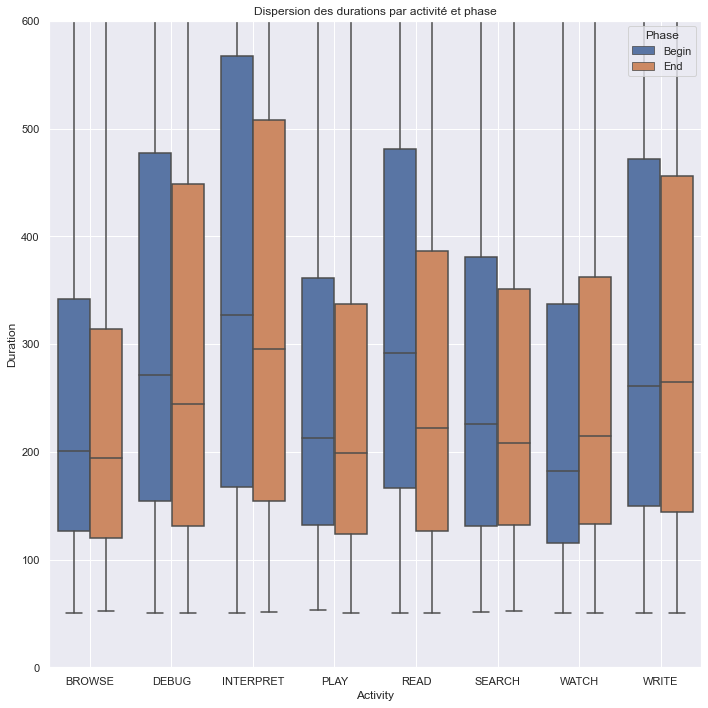

In [117]:
# Initialisation du dictionnaire pour stocker les données
data_dict = {"Activity": [], "Phase": [], "Duration": []}

# Boucle sur les participants et les activités pour récupérer les données
for participant in participants:
    for activity in activities:
        # Chargement des données pour le participant et l'activité courants
        filename = "Fixations_Features/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        
         # Sélectionner les premières et dernières lignes
        begin_data = data[data["Time"] <= 30000].dropna()
        end_data = data[data["Time"] > (data["Time"].max() - 30000)].dropna()
        
        # Ajout des durations du début d'activité dans le dictionnaire
        data_dict["Activity"].extend([activity] * len(begin_data))
        data_dict["Phase"].extend(["Begin"] * len(begin_data))
        data_dict["Duration"].extend(begin_data["Duration"].tolist())
        
        # Ajout des durations de la fin d'activité dans le dictionnaire
        data_dict["Activity"].extend([activity] * len(end_data))
        data_dict["Phase"].extend(["End"] * len(end_data))
        data_dict["Duration"].extend(end_data["Duration"].tolist())

# Conversion du dictionnaire en DataFrame
results_df = pd.DataFrame(data_dict)

# Affichage des résultats
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="Activity", y="Duration", hue="Phase", data=results_df)
ax.set_xlabel("Activity")
ax.set_ylabel("Duration")
ax.set_ylim([0, 600])  # Tronquer l'axe y 
ax.set_title("Dispersion des durations par activité et phase")
plt.tight_layout()
plt.grid(True)
plt.show()


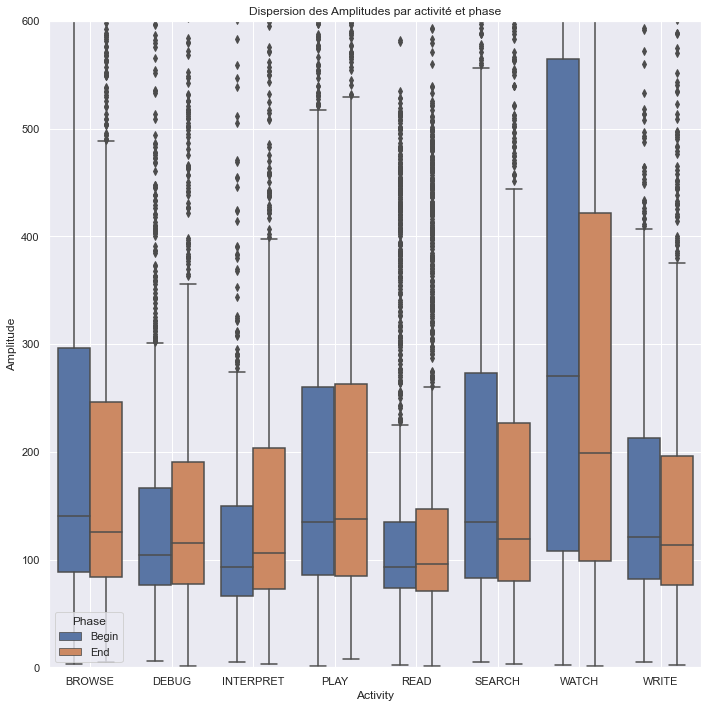

In [118]:
# Initialisation du dictionnaire pour stocker les données
data_dict = {"Activity": [], "Phase": [], "Amplitude": []}

# Boucle sur les participants et les activités pour récupérer les données
for participant in participants:
    for activity in activities:
        # Chargement des données pour le participant et l'activité courants
        filename = "Saccades_Features/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        
         # Sélectionner les premières et dernières lignes
        begin_data = data[data["Time"] <= 30000].dropna()
        end_data = data[data["Time"] > (data["Time"].max() - 30000)].dropna()
        
        # Ajout des durations du début d'activité dans le dictionnaire
        data_dict["Activity"].extend([activity] * len(begin_data))
        data_dict["Phase"].extend(["Begin"] * len(begin_data))
        data_dict["Amplitude"].extend(begin_data["Amplitude"].tolist())
        
        # Ajout des durations de la fin d'activité dans le dictionnaire
        data_dict["Activity"].extend([activity] * len(end_data))
        data_dict["Phase"].extend(["End"] * len(end_data))
        data_dict["Amplitude"].extend(end_data["Amplitude"].tolist())

# Conversion du dictionnaire en DataFrame
results_df2 = pd.DataFrame(data_dict)

# Affichage des résultats
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="Activity", y="Amplitude", hue="Phase", data=results_df2)
ax.set_xlabel("Activity")
ax.set_ylabel("Amplitude")
ax.set_ylim([0, 600]) 
ax.set_title("Dispersion des Amplitudes par activité et phase")
plt.tight_layout()
plt.grid(True)
plt.show()


L'analyse des données met en évidence des différences intéressantes concernant les durées et les amplitudes des fixations et des saccades au début et à la fin de chaque activité.

> Durées :
> Nous observons que les durées moyennes des fixations sont généralement similaires au début et à la fin de chaque activité, à l'exception de l'activité Read où les fixations moyennes sont plus longues en début d'activité. Cela suggère que les participants ont tendance à maintenir leur regard plus longtemps au début de l'activité de lecture.

> Les variations des durées de fixations restent relativement similaires entre le début et la fin de chaque activité, sauf pour les activités Interpret et Read où les durées sont globalement plus longues au début. Cela signifie que la variabilité des durées de fixations reste stable tout au long de l'activité, indépendamment de la phase, à l'exception de l'activité de lecture et d'interprétation où les durées sont plus longues au début.

> Amplitudes :

> En ce qui concerne les amplitudes des saccades, les moyennes sont similaires entre le début et la fin de chaque activité, sauf pour l'activité Watch où les amplitudes moyennes sont plus élevées. Cela suggère que, en moyenne, les participants effectuent des saccades de même amplitude, quelle que soit la phase de l'activité, sauf lorsqu'ils regardent quelque chose.

> Cependant, contrairement aux durées, les dispersions des amplitudes des saccades varient entre le début et la fin de chaque activité. Sur certaines activités, la dispersion est plus importante au début, tandis que sur d'autres, elle est plus importante à la fin. Plus spécifiquement, la dispersion des amplitudes est plus marquée au début de l'activité Watch, ce qui indique une plus grande variabilité dans les mouvements oculaires des participants lorsqu'ils commencent à regarder quelque chose.

Ces résultats suggèrent que les caractéristiques des mouvements oculaires peuvent varier en fonction du type d'activité et de la phase dans laquelle les participants se trouvent. Par exemple, la durée des fixations peut être influencée par le type d'activité, tandis que la dispersion des amplitudes des saccades peut varier au cours de l'activité. Ces différences peuvent refléter des processus cognitifs et perceptifs spécifiques associés à chaque activité..

# Phase 2 - Manipulation

Ainsi, nous tenterons de répondre à la question suivante : 
## Peut-on distinguer le début et la fin d’une activité en fonction des mouvements occulaires ?

### Hypothèses : 
- La durée des fixations pourrait être plus longue au début et à la fin d'une activité, reflétant une concentration accrue ou une fatigue visuelle.
- La position en X et en Y des fixations pourrait varier en fonction de l'activité réalisée, certaines activités nécessitant une attention plus centrée sur l'écran, tandis que d'autres pourraient impliquer une exploration plus large de l'écran.
- La position en X et en Y des fixations pourrait être davantage concentrée vers le centre de l'écran, en raison du biais centré. Cependant, certaines activités spécifiques pourraient nécessiter une attention plus centrée, entraînant une position de fixation plus précise et focalisée.
- L'amplitude des saccades pourrait être plus courte au début et à la fin d'une activité, indiquant une exploration plus détaillée de l'écran ou une fatigue visuelle.
- Les participants pourraient montrer des schémas de fixation et de saccade différents en fonction de leur expertise ou de leur familiarité avec l'activité en cours.



<i>"La fatigue peut réduire la vitesse, la durée et l'amplitude des mouvements saccadiques de l'oeil"

F. Cail, S. Salsi. La fatigue visuelle.. [Rapport de recherche] Notes scientifiques et techniques de l’INRS
NS 92, Institut National de Recherche et de Sécurité (INRS). 1992, 58 p., ill., bibliogr. ffhal-01420177

Afin de répondre à cette question et de vérifier nos hypothèses, nous utiliserons les features suivants : 

- 9 zones : nous allons diviser notre écran en 9 zones différentes afin de savoir si les points de fixations sont ou non dans ces zones. Il s'agit donc de 9 variables binaires.
- Amplitude (on supprime la première ou la dernière ligne)
- duration : il s'agit du temps de fixation
- temporalité : il s'agit d'une variable qui caractérise le moment de l'activité, 0 pour la première moitié de l'activité et 1 pour la deuxième moitié.

## Création des différentes divisions


Nous commençons par calculer la taille de l'écran moyen de toutes les activités

Nous allons initialiser un dictionnaire pour stocker les dimensions des écrans par activité. En parcourant les activités, nous récupérons les dimensions maximales des écrans en bouclant sur les participants et en extrayant les positions maximales des données correspondantes, stockant ensuite les dimensions maximales pour chaque activité dans le dictionnaire "screen_sizes".

In [119]:
# Initialisation du dictionnaire pour stocker les dimensions des écrans par activité
screen_sizes = {}

# Boucle sur les activités pour récupérer les dimensions maximales des écrans
for activity in activities:
    # Initialisation des positions maximales à 0
    max_pos_x = 0
    max_pos_y = 0
    # Boucle sur les participants pour récupérer les positions maximales pour l'activité courante
    for participant in participants:
        # Chargement des données pour le participant et l'activité courants
        filename = "Fixations_Features/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        # Récupération des positions maximales pour l'activité courante et le participant courant
        max_x = data["PosX"].max()
        max_y = data["PosY"].max()
        # Mise à jour des positions maximales pour l'activité courante
        if max_x > max_pos_x:
            max_pos_x = max_x
        if max_y > max_pos_y:
            max_pos_y = max_y
    # Stockage des dimensions maximales pour l'activité courante dans le dictionnaire screen_sizes
    screen_sizes[activity] = (max_pos_x, max_pos_y)
screen_sizes

{'BROWSE': (2243.0, 1749.0),
 'DEBUG': (1915.0, 1603.0),
 'INTERPRET': (1952.0, 1541.0),
 'PLAY': (2052.0, 1575.0),
 'READ': (1892.0, 1272.0),
 'SEARCH': (2865.0, 1639.0),
 'WATCH': (2717.0, 1386.0),
 'WRITE': (1989.0, 1789.0)}

Nous supposons que les écrans utilisés par les participants sont des écrans 2K de taille 2560 x 1440. Nous allons vérifier les points de fixation en dehors de cette zone.

Nous allons initialiser des variables pour compter les fixations et les positions de regard en dehors des limites de l'écran. En parcourant les participants et les activités, nous chargerons les données correspondantes, compterons le nombre total de fixations, déterminerons les lignes où les positions de regard se trouvent en dehors des limites de l'écran, et ajouterons le nombre de ces lignes au compteur "horsecran". Enfin, nous calculerons la proportion de positions de regard en dehors des limites de l'écran et afficherons les résultats.

In [120]:
# Initialiser des variables pour compter les fixations et les positions de regard en dehors des limites de l'écran
total_fixations = 0
horsecran = 0

# Boucler sur les participants et les activités pour récupérer les durées de fixation
for participant in participants:
    for activity in activities:
        # Charger les données pour le participant et l'activité courants
        filename = "Fixations_Features/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        
        posX = data["PosX"].astype(float)
        posY = data["PosY"].astype(float)

        # Compter le nombre total de fixations
        total_fixations += len(data)
        
        # Créer un masque booléen pour les lignes où posX ou posY sont en dehors des limites de l'écran
        outside_bounds = (posX > 2560) | (posX < 0) | (posY > 1440) | (posY < 0)

        # Ajouter au compteur horsecran le nombre de lignes qui sont en dehors des limites de l'écran
        horsecran += outside_bounds.sum()

# Calculer la proportion de positions de regard en dehors des limites de l'écran
proportion_horsecran = horsecran / total_fixations

# Afficher les résultats
print("Nombre total de fixations : {}".format(total_fixations))
print("Nombre de positions de regard en dehors des limites de l'écran : {}".format(horsecran))
print("Proportion de positions de regard en dehors des limites de l'écran : {:.2%}".format(proportion_horsecran))


Nombre total de fixations : 112678
Nombre de positions de regard en dehors des limites de l'écran : 1763
Proportion de positions de regard en dehors des limites de l'écran : 1.56%


Nous constatons que seuls 1.56% des fixations sont en dehors des limites d'un écran 2K. Nous allons donc garder cette dimension.

In [121]:
#taille ecran 2k on considère qu'il y a eu debordement
 # Création des divisions
x_divisions = np.linspace(0, 2560, 4)
y_divisions = np.linspace(0, 1440, 4)
print(x_divisions, y_divisions)

[   0.          853.33333333 1706.66666667 2560.        ] [   0.  480.  960. 1440.]



Nous allons créer des noms de fichiers pour chaque personne et activité. Si le dossier "Fixations_Divisions" n'existe pas, nous le créerons. Ensuite, en parcourant les participants et les activités, nous créerons les fichiers de données avec les divisions. Pour chaque fichier, nous récupérerons les données de fixations correspondantes, créerons un DataFrame pour stocker les données des divisions, et ajouterons les données de chaque fixation avec la division correspondante. Enfin, nous enregistrerons le DataFrame dans un fichier CSV.

In [122]:
# Création des noms de fichiers pour chaque personne et activité

# Création du dossier Fixations_Divisions s'il n'existe pas déjà
if not os.path.exists("Fixations_Divisions"):
    os.makedirs("Fixations_Divisions")

filenames = []

for participant in participants:
    for activity in activities:
        filenames.append("Fixations_Divisions/{}_{}.csv".format(participant, activity))

# Boucle sur les participants et les activités pour créer les fichiers de données avec les divisions
for i, filename in enumerate(filenames):
    # Récupération des données de fixations pour le participant et l'activité courants

    fixations_filename = "Fixations_Features/{}_{}.csv".format(participant, activity)
    data = pd.read_csv(fixations_filename)

    # Création du DataFrame pour stocker les données des divisions
    divisions_data = pd.DataFrame(columns=["Duration", "Time", "PosX", "PosY", "Division_1", "Division_2", "Division_3", "Division_4", "Division_5", "Division_6", "Division_7", "Division_8", "Division_9"])

    # Boucle sur les fixations pour ajouter les données des divisions au DataFrame
    for index, row in data.iterrows():
        duration = row["Duration"]
        time = row["Time"]
        pos_x = row["PosX"]
        pos_y = row["PosY"]

        # Détermination de la division dans laquelle se trouve la fixation
        for i in range(len(y_divisions) - 1):
            for j in range(len(x_divisions) - 1):
                if y_divisions[i] <= pos_y < y_divisions[i+1] and x_divisions[j] <= pos_x < x_divisions[j+1]:
                    division = "Division_" + str(i * (len(x_divisions)-1) + j + 1)
                    break

        # Ajout des données de la fixation avec la division correspondante
        divisions_data.loc[index] = [duration, time, pos_x, pos_y] + [1 if div == division else 0 for div in divisions_data.columns[4:]]

    # Enregistrement du DataFrame dans un fichier CSV
    divisions_data.to_csv(filename, index=False)


## Ajout des amplitudes dans les fichiers
Pour ajouter amplitudes, il faut utiliser le dossier Saccades_features. Les timestamp comprennent le temps de début de fixation + la durée de la saccade. Pour pouvoir ajouter ces colonnes à nos fixations, il faut que les timestamp match.


Nous allons parcourir les participants et les activités pour traiter chaque fichier CSV. Pour chaque fichier, nous chargerons les données dans un DataFrame, calculerons la nouvelle colonne "time_calcul" en ajoutant la colonne "Time" à la colonne "Duration", et enregistrerons le DataFrame modifié dans le fichier CSV.

Ensuite, nous parcourrons à nouveau les participants et les activités pour traiter chaque fichier CSV. Pour chaque fichier "Fixations_Divisions" et "Saccades_Features", nous chargerons les données dans deux DataFrames distincts. Nous ajouterons ensuite la colonne "Amplitude" de "Saccades_Features" à "Fixations_Divisions" en utilisant la méthode "join" de Pandas. Enfin, nous enregistrerons le DataFrame modifié dans le fichier CSV correspondant.

In [123]:
# Boucle sur les participants et les activités pour traiter chaque fichier CSV
for participant in participants:
    for activity in activities:
        # Définition du nom de fichier et du chemin d'accès complet
        filename = "Fixations_Divisions/{}_{}.csv".format(participant, activity)
        full_path = os.path.abspath(filename)

        # Chargement des données de fichier CSV dans un DataFrame
        data = pd.read_csv(full_path)

        # Calcul de la nouvelle colonne "time_calcul"
        data["time_calcul"] = data["Time"] + data["Duration"]

        # Enregistrement du DataFrame modifié dans le fichier CSV
        data.to_csv(full_path, index=False)
# Boucle sur les participants et les activités pour traiter chaque fichier CSV
for participant in participants:
    for activity in activities:
        # Définition des noms de fichiers et du chemin d'accès complet pour les fichiers "Fixations_divisions" et "Saccades_features"
        fixations_filename = "Fixations_Divisions/{}_{}.csv".format(participant, activity)
        saccades_filename = "Saccades_Features/{}_{}.csv".format(participant, activity)
        fixations_full_path = os.path.abspath(fixations_filename)
        saccades_full_path = os.path.abspath(saccades_filename)

        # Chargement des données de fichier CSV pour "Fixations_divisions" et "Saccades_features" dans deux DataFrames
        fixations_data = pd.read_csv(fixations_full_path)
        saccades_data = pd.read_csv(saccades_full_path)

        # Ajout de la colonne "Amplitude" de "Saccades_features" à "Fixations_divisions" en utilisant la méthode "join" de Pandas
        fixations_data = fixations_data.join(saccades_data["Amplitude"])

        # Enregistrement du DataFrame modifié dans le fichier CSV
        fixations_data.to_csv(fixations_full_path, index=False)

Maintenant pour chaque fichier dans Fixations_divisions verifions qu'il n'y a pas de nul et que la jointure s'est bien faite.

In [124]:
# Boucle sur les participants et les activités pour traiter chaque fichier CSV
for participant in participants:
    for activity in activities:
        # Définition des noms de fichiers et du chemin d'accès complet pour les fichiers "Fixations_divisions" et "Saccades_features"
        fixations_filename = "Fixations_Divisions/{}_{}.csv".format(participant, activity)
        fixations_full_path = os.path.abspath(fixations_filename)

        # Chargement des données de fichier CSV pour "Fixations_divisions" et "Saccades_features" dans deux DataFrames
        fixations_data = pd.read_csv(fixations_full_path)

    if fixations_data["Amplitude"].isnull().sum() >0 :
                print("Le fichier {} contient des valeurs nulles dans la colonne Amplitude.".format(fixations_full_path))
    else:
        pass

Le fichier /Users/christelleravon/Desktop/M1/SAE-IA/Fixations_Divisions/P18_WRITE.csv contient des valeurs nulles dans la colonne Amplitude.
Le fichier /Users/christelleravon/Desktop/M1/SAE-IA/Fixations_Divisions/P24_WRITE.csv contient des valeurs nulles dans la colonne Amplitude.


In [125]:
# Lecture du fichier Fixations
fixations_data = pd.read_csv("Fixations_Divisions/P18_WRITE.csv")

# Lecture du fichier Saccades
saccades_data = pd.read_csv("Saccades_Features/P18_WRITE.csv")

# Affichage de la taille de chaque DataFrame
print("Taille de Fixations :", fixations_data.shape)
print("Taille de Saccades :", saccades_data.shape)

Taille de Fixations : (253, 15)
Taille de Saccades : (238, 8)


In [126]:
import pandas as pd

# Lecture du fichier Fixations
fixations_data = pd.read_csv("Fixations_Divisions/P24_WRITE.csv")

# Lecture du fichier Saccades
saccades_data = pd.read_csv("Saccades_Features/P24_WRITE.csv")

# Affichage de la taille de chaque DataFrame
print("Taille de Fixations :", fixations_data.shape)
print("Taille de Saccades :", saccades_data.shape)

Taille de Fixations : (253, 15)
Taille de Saccades : (252, 8)


Nous remarquons qu'il manque des données pour le participant 18 et 24 sur l'activité WRITE mais nous ne savons pas à quoi cela est dû. 

## Ajout de la temporalité
La temporalité est la variable à laquelle nous nous interesserons de près. En effet, nous allons faire entre sorte de diviser les temps d'activités en 2 parties : début (0) et fin (1). Pour cela, il nous suffit simplement de diviser le temps des activités et d'y attribuer 0 (début) si la ligne correspond à un temps inférieur à la moitié de la durée de l'actiivté et 1 sinon (fin).

C'est dont bien cette variable là que nous chercherons à prédire plus tard avec nos apprentissages afin de déterminer le moment de l'activité. 

In [127]:
# Boucler sur les activités
for activity in activities:
    # Boucler sur les participants
    for participant in participants:
        # Charger les données pour le participant et l'activité courants
        filename = "Fixations_Divisions/{}_{}.csv".format(participant, activity)
        data = pd.read_csv(filename)
        
        # Ajouter la variable binaire temporalite
        data["temporalite"] = np.where(data["Time"] <= 149131, 0, 1)
        
        # Sauvegarder les données modifiées dans le fichier CSV d'origine
        data.to_csv(filename, index=False)


Afin de bien distinguer le début de la fin d'une activité et que nous résultats soient plus probants, nous n'allons utiliser uniquement les 30 premières secondes et les 30 dernieres secondes de chaque participants sur chaque activité. 

## Création d'un fichier .csv avec les 30 premières secondes de chaque participant sur chaque activité

Nous allons définir le nombre de lignes à prendre pour chaque partie. Ensuite, nous initialiserons le DataFrame final. En parcourant les activités et les participants, nous chargerons les données correspondantes pour chaque participant et activité, supprimerons la colonne "time_calcul", sélectionnerons les premières et dernières lignes en fonction des conditions spécifiées, concaténerons les deux parties et ajouterons les colonnes "Participant" et "Activite". Enfin, nous ajouterons les lignes sélectionnées au DataFrame final, et sauvegarderons le DataFrame final dans un fichier CSV nommé "df_fin.csv".

In [128]:
# Définir le nombre de lignes à prendre pour chaque partie

# Initialiser le DataFrame final
df = pd.DataFrame(columns=["Participant", "Activite"])

# Boucler sur les activités
for activity in activities:
    # Boucler sur les participants
    for participant in participants:
        # Charger les données pour le participant et l'activité courants
        fixations_filename = "Fixations_Divisions/{}_{}.csv".format(participant, activity)
        fixations_data = pd.read_csv(fixations_filename)
        fixations_data.drop("time_calcul", axis=1, inplace=True)

        # Sélectionner les premières et dernières lignes
        first_lines = fixations_data[fixations_data["Time"] <= 30000].dropna()
        last_lines = fixations_data[fixations_data["Time"] > (fixations_data["Time"].max() - 30000)].dropna()
        
        # Concaténer les deux parties et ajouter les colonnes Participant et Activite
        selected_lines = pd.concat([first_lines, last_lines])
        selected_lines["Participant"] = participant
        selected_lines["Activite"] = activity
        
        # Ajouter les lignes sélectionnées au DataFrame final
        df = pd.concat([df, selected_lines])

# Sauvegarder le DataFrame final dans un fichier CSV
df.to_csv("df_fin.csv", index=False)

## Lecture du dataframe final

In [129]:
fin = pd.read_csv("df_fin.csv")
fin.head()

Participant Activite  Duration    Time   PosX   PosY  Division_1  \
0         P01   BROWSE     186.0   101.0  199.0  334.0         1.0   
1         P01   BROWSE     251.0   356.0  158.0  277.0         1.0   
2         P01   BROWSE     773.0   670.0  148.0  196.0         1.0   
3         P01   BROWSE     320.0  1510.0  295.0  191.0         1.0   
4         P01   BROWSE     638.0  1892.0  368.0  183.0         1.0   

   Division_2  Division_3  Division_4  Division_5  Division_6  Division_7  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   Division_8  Division_9    Amplitude  temporalite  
0         0.0         0.0   702.214355          0.0  
1         0.0         0.0   775.465022          0.0  
2         0.0         0.0   751.862354          0.0  
3         0.0         0.0  1273.543482          0.0  
4         0.0         0.0  1140.105697          0.0

In [130]:
fin.shape

(11212, 17)

In [131]:
fin.columns

Index(['Participant', 'Activite', 'Duration', 'Time', 'PosX', 'PosY',
       'Division_1', 'Division_2', 'Division_3', 'Division_4', 'Division_5',
       'Division_6', 'Division_7', 'Division_8', 'Division_9', 'Amplitude',
       'temporalite'],
      dtype='object')

### Quelques vérifications sur le df final

In [132]:
fin.nunique()

Participant      24
Activite          8
Duration         57
Time             59
PosX             55
PosY             57
Division_1        2
Division_2        2
Division_3        1
Division_4        2
Division_5        2
Division_6        1
Division_7        1
Division_8        1
Division_9        1
Amplitude      7644
temporalite       2
dtype: int64

In [133]:
fin.isnull().sum()

Participant    0
Activite       0
Duration       0
Time           0
PosX           0
PosY           0
Division_1     0
Division_2     0
Division_3     0
Division_4     0
Division_5     0
Division_6     0
Division_7     0
Division_8     0
Division_9     0
Amplitude      0
temporalite    0
dtype: int64

# Phase 3 - Apprentissage

### Peut-on distinguer le début et la fin d’une activité ? / Peut-on distinguer le moment de l’activité en cours ? 


Pour rappel, nos features sont : 
- 9 zones, variables binaires, allant de Division_1 à Division_9
- Amplitude
- duration : il s'agit du temps de fixation

On cherche à prédire
- temporalité 

# Apprentissage supervisé

# CLASSIFICATION

In [134]:
# On utiliser la fonction read_csv pour transférer les données du fichier .csv à un dataframe Pandas
data = pd.read_csv('df_fin.csv')

In [135]:
data.shape

(11212, 17)

In [136]:
# On utilise la méthode .head() sur un dataframe pour afficher les 5 premières lignes.
# Cela va nous donner une idée de la structure générale du dataframe
data.head()

Participant Activite  Duration    Time   PosX   PosY  Division_1  \
0         P01   BROWSE     186.0   101.0  199.0  334.0         1.0   
1         P01   BROWSE     251.0   356.0  158.0  277.0         1.0   
2         P01   BROWSE     773.0   670.0  148.0  196.0         1.0   
3         P01   BROWSE     320.0  1510.0  295.0  191.0         1.0   
4         P01   BROWSE     638.0  1892.0  368.0  183.0         1.0   

   Division_2  Division_3  Division_4  Division_5  Division_6  Division_7  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   Division_8  Division_9    Amplitude  temporalite  
0         0.0         0.0   702.214355          0.0  
1         0.0         0.0   775.465022          0.0  
2         0.0         0.0   751.862354          0.0  
3         0.0         0.0  1273.543482          0.0  
4         0.0         0.0  1140.105697          0.0

## Analyse et description des données
Pour commencer, nous allons étudier les données à disposition. En particulier, on souhaite faire la distinction entre les variables catégorielles et les variables numériques.

In [137]:
data.columns

Index(['Participant', 'Activite', 'Duration', 'Time', 'PosX', 'PosY',
       'Division_1', 'Division_2', 'Division_3', 'Division_4', 'Division_5',
       'Division_6', 'Division_7', 'Division_8', 'Division_9', 'Amplitude',
       'temporalite'],
      dtype='object')


Nous allons travailler avec trois listes de variables : "categorical_list" contenant les variables catégoriques telles que "Participant", "Activite", "Division_1", ..., "Division_9" et "temporalite", "numerical_list" contenant les variables numériques telles que "Duration" et "Amplitude", et "autres_list" contenant les variables restantes comme "PosX", "PosY" et "Time".

In [138]:
categorical_list = ['Participant', 'Activite', 'Division_1', 'Division_2', 'Division_3', 'Division_4', 'Division_5', 'Division_6', 'Division_7', 'Division_8', 'Division_9','temporalite']
numerical_list = ['Duration','Amplitude']
autres_list = ['PosX', 'PosY','Time']

On veut également détecter les variables contenant  des valeurs nulles ou vides. Pour cela, on va utiliser la méthode isna() pour détecter les valeurs nulles, puis sum() pour les compter.

In [139]:
data.isna().sum()

Participant    0
Activite       0
Duration       0
Time           0
PosX           0
PosY           0
Division_1     0
Division_2     0
Division_3     0
Division_4     0
Division_5     0
Division_6     0
Division_7     0
Division_8     0
Division_9     0
Amplitude      0
temporalite    0
dtype: int64

On va s'intéresser un petit peu aux variables numériques. Pour cela, on va utiliser la méthode describe().

In [140]:
data[numerical_list].describe()

Duration     Amplitude
count  11212.000000  11212.000000
mean     447.360774    216.675367
std      561.069796    244.530664
min       53.000000      2.000000
25%      131.000000     80.006250
50%      222.000000    120.027080
75%      559.000000    249.071274
max     2930.000000   1992.000251

On va également s'intéresser à la distribution des variables catégorielles. On va utiliser la même méthode, mais avec un argument permettant de considérer ce type de variables.

In [141]:
data[categorical_list].describe(include=['O'])

Participant Activite
count        11212    11212
unique          24        8
top            P01   BROWSE
freq           472     1416

Nous allons maintenant changer les variables catégoriques de type objet.

Nous allons remplacer les valeurs de la colonne "Participant" par des nombres correspondants en utilisant la notation "P01" à "P24". Ensuite, nous créerons un dictionnaire de mappage pour remplacer les valeurs de la colonne "Activite" par des nombres. Enfin, nous remplacerons les valeurs de la colonne "Activite" par les nombres correspondants en utilisant le dictionnaire de mappage.

In [142]:
# Remplacer les valeurs de "Participant" par un nombre correspondant
for i in range(1, 25):
    participant = f'P{i:02}'
    data['Participant'] = data['Participant'].replace(participant, i)

# Créer un dictionnaire de mapping pour remplacer les valeurs de la colonne "Activite" par des nombres
activite_mapping = {'WRITE':1, 'READ':2, 'WATCH':3, 'BROWSE':4, 'DEBUG':5, 'INTERPRET':6, 'PLAY':7, 'SEARCH':8}

# Remplacer les valeurs de la colonne "Activite" par les nombres correspondants
data["Activite"] = data["Activite"].replace(activite_mapping)


In [143]:
data = data.drop(columns=['PosX', 'PosY', 'Time'])

In [144]:
data.head()

Participant  Activite  Duration  Division_1  Division_2  Division_3  \
0            1         4     186.0         1.0         0.0         0.0   
1            1         4     251.0         1.0         0.0         0.0   
2            1         4     773.0         1.0         0.0         0.0   
3            1         4     320.0         1.0         0.0         0.0   
4            1         4     638.0         1.0         0.0         0.0   

   Division_4  Division_5  Division_6  Division_7  Division_8  Division_9  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

     Amplitude  temporalite  
0   702.214355          0.0  
1   775.465022          0.0  
2   751.862354          0.0  
3  1273.543482          0.0  
4  1140.105697          0.0

Nous allons commencer par constituer un ensemble d'entrainement, ainsi qu'un ensemble de test. Le dataset est composé de 891 échantillons. Nous allons en conserver 80% pour l'entrainement, et garder les 20% restants pour l'évaluation.

## Modèle 1

In [145]:
# On commence par générer un nombre aléatoire entre 0 et 1 pour chaque ligne du dataframe.
# On vient ensuite conserver la ligne dans les données d'entrainement si le nombre est inférieur à 0.8 (i.e. 80% du temps environ), 
# et de test si le nombre est supérieur à 0.8

msk = np.random.rand(len(data)) < 0.8

train = data[msk]
test = data[~msk]

Il ne reste plus qu'une chose à faire : séparer la variable à prédire (i.e. le label) des autres variables
Le but est de prédire Temporalite donc on le supprime.

In [146]:
X_train = train.drop("temporalite", axis=1)
Y_train = train["temporalite"]
X_test = test.drop("temporalite", axis=1)
Y_test = test["temporalite"]

In [147]:
train.shape

(8932, 14)

In [148]:
test.shape

(2280, 14)

## SVC

Maintenant que nos données sont prêtes, on va pouvoir entraîner un modèle.

Prenons par exemple un SVC

In [149]:
# Créer le modèle SVC et l'entraîner sur l'ensemble d'entraînement
svc = sklearn.svm.SVC()
svc.fit(X_train, Y_train)

# Prédire les étiquettes sur l'ensemble de test
Y_pred = svc.predict(X_test)

# Évaluer le modèle sur l'ensemble de test
score = svc.score(X_test, Y_test)
print("Score du modèle SVC : {:.2f}".format(score))

Score du modèle SVC : 0.66


In [150]:
# Calculer le score F1
f1 = f1_score(Y_test, Y_pred)

print("Score F1 du modèle SVC : {:.2f}".format(f1))

Score F1 du modèle SVC : 0.05


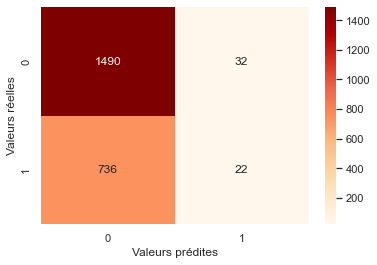

In [151]:
# Calculer la matrice de confusion
cm = confusion_matrix(Y_test, Y_pred)

# Créer la carte de chaleur
sns.heatmap(cm, annot=True, cmap="OrRd", fmt='g')

# Ajouter les labels des axes
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Afficher la carte de chaleur
plt.show()

In [152]:
zero = np.zeros(len(Y_pred)) # modèle avec que des 0
sklearn.metrics.accuracy_score(zero, Y_test)

0.6675438596491228

Le modèle semble toujours prédire la même valeur. A savoir : 0. 

Après analyse des données, nous supposons que cela est du au fait qu'il y ait plus de lignes qui concernent le début d'une activité que la fin. En effet, si l'on choisit les 30 premières secondes de début et de fin, on remarque qu'il y a plus de fixations au début donc plus de lignes à 0.

Cela est confirmé par le score F1 qui est de 0. 

Nous pouvons rééquilibrer cela en choisissant de ne prendre que les 30 premières et les 30 dernières lignes au lieu des 30 premières et 30 dernières secondes pour avoir un nombre équivalent pour les 2 temporalités de l'activité.

## Modèle 2

In [153]:
# Définir le nombre de lignes à prendre pour chaque partie
num_lines = 30

# Boucler sur les activités
for activity in activities:
    # Boucler sur les participants
    for participant in participants:
        # Charger les données pour le participant et l'activité courants
        fixations_filename = "Fixations_Divisions/{}_{}.csv".format(participant, activity)
        fixations_data = pd.read_csv(fixations_filename)
        fixations_data.drop("time_calcul", axis=1, inplace=True)

        # Sélectionner les premières et dernières lignes
        first_lines = fixations_data.head(num_lines).dropna()
        last_lines = fixations_data.tail(num_lines).dropna()
        
        # Concaténer les deux parties et ajouter les colonnes Participant et Activite
        selected_lines = pd.concat([first_lines, last_lines])
        selected_lines["Participant"] = participant
        selected_lines["Activite"] = activity
        
        # Ajouter les lignes sélectionnées au DataFrame final
        df = pd.concat([df, selected_lines])

# Sauvegarder le DataFrame final dans un fichier CSV
df.to_csv("df_fin_30lignes.csv", index=False)

In [154]:
# On utiliser la fonction read_csv pour transférer les données du fichier .csv à un dataframe Pandas
data_bis = pd.read_csv('df_fin_30lignes.csv')

In [155]:
data_bis.shape

(22566, 17)

In [156]:
data_bis.isna().sum()

Participant    0
Activite       0
Duration       0
Time           0
PosX           0
PosY           0
Division_1     0
Division_2     0
Division_3     0
Division_4     0
Division_5     0
Division_6     0
Division_7     0
Division_8     0
Division_9     0
Amplitude      0
temporalite    0
dtype: int64

In [157]:
data_bis[numerical_list].describe()

Duration     Amplitude
count  22566.000000  22566.000000
mean     457.153594    215.656908
std      573.535225    242.529762
min       53.000000      2.000000
25%      131.000000     79.924965
50%      238.000000    119.707978
75%      542.000000    249.379729
max     2930.000000   1992.000251

In [158]:
data_bis[categorical_list].describe(include=['O'])

Participant Activite
count        22566    22566
unique          24        8
top            P01   BROWSE
freq           952     2856

In [159]:
# On utilise la méthode .head() sur un dataframe pour afficher les 5 premières lignes.
# Cela va nous donner une idée de la structure générale du dataframe
data_bis.head()

Participant Activite  Duration    Time   PosX   PosY  Division_1  \
0         P01   BROWSE     186.0   101.0  199.0  334.0         1.0   
1         P01   BROWSE     251.0   356.0  158.0  277.0         1.0   
2         P01   BROWSE     773.0   670.0  148.0  196.0         1.0   
3         P01   BROWSE     320.0  1510.0  295.0  191.0         1.0   
4         P01   BROWSE     638.0  1892.0  368.0  183.0         1.0   

   Division_2  Division_3  Division_4  Division_5  Division_6  Division_7  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   Division_8  Division_9    Amplitude  temporalite  
0         0.0         0.0   702.214355          0.0  
1         0.0         0.0   775.465022          0.0  
2         0.0         0.0   751.862354          0.0  
3         0.0         0.0  1273.543482          0.0  
4         0.0         0.0  1140.105697          0.0

In [160]:
# Remplacer les valeurs de "Participant" par un nombre correspondant
for i in range(1, 25):
    participant = f'P{i:02}'
    data_bis['Participant'] = data_bis['Participant'].replace(participant, i)

# Créer un dictionnaire de mapping pour remplacer les valeurs de la colonne "Activite" par des nombres
activite_mapping = {'WRITE':1, 'READ':2, 'WATCH':3, 'BROWSE':4, 'DEBUG':5, 'INTERPRET':6, 'PLAY':7, 'SEARCH':8}

# Remplacer les valeurs de la colonne "Activite" par les nombres correspondants
data_bis["Activite"] = data_bis["Activite"].replace(activite_mapping)

In [161]:
data_bis = data_bis.drop(columns=['PosX', 'PosY', 'Time'])

In [162]:
msk = np.random.rand(len(data_bis)) < 0.8

train_bis = data_bis[msk]
test_bis = data_bis[~msk]

In [163]:
X_train_bis = train_bis.drop("temporalite", axis=1)
Y_train_bis = train_bis["temporalite"]
X_test_bis = test_bis.drop("temporalite", axis=1)
Y_test_bis = test_bis["temporalite"]

In [164]:
train_bis.shape

(18069, 14)

In [165]:
test_bis.shape

(4497, 14)

In [166]:
# Créer le modèle SVC et l'entraîner sur l'ensemble d'entraînement
svc_bis = sklearn.svm.SVC()
svc_bis.fit(X_train_bis, Y_train_bis)

# Prédire les étiquettes sur l'ensemble de test
Y_pred_bis = svc_bis.predict(X_test_bis)

# Évaluer le modèle sur l'ensemble de test
score_bis = svc.score(X_test_bis, Y_test_bis)
print("Score du modèle SVC : {:.2f}".format(score_bis))

Score du modèle SVC : 0.60


In [167]:
# Calculer le score F1
f1 = f1_score(Y_test_bis, Y_pred_bis)

print("Score F1 du modèle SVC : {:.2f}".format(f1))

Score F1 du modèle SVC : 0.41


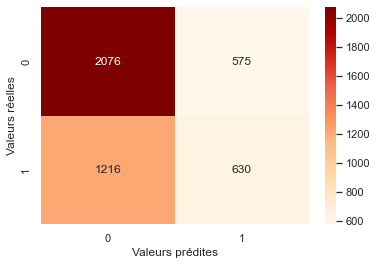

In [168]:
# Calculer la matrice de confusion
cm_bis = confusion_matrix(Y_test_bis, Y_pred_bis)

# Créer la carte de chaleur
sns.heatmap(cm_bis, annot=True, cmap="OrRd", fmt='g')

# Ajouter les labels des axes
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Afficher la carte de chaleur
plt.show()

In [169]:
zero = np.zeros(len(Y_pred_bis)) # modèle avec que des 0
sklearn.metrics.accuracy_score(zero, Y_test_bis)

0.5895041138536802

Ce modèle semble être un meilleur modèle que le précédent.

Le score  obtenu, ce qui indique une précision relativement modérée dans la classification des données. Cela signifie que le modèle a réussi à classer correctement environ 60 % des échantillons.

Un score F1 d'environ 0.40 suggère une performance globalement moyenne du modèle, où l'équilibre entre la précision et le rappel peut être amélioré.

Le modèle SVC semble avoir une précision modérée, mais il y a encore une marge d'amélioration en termes de performances globales.

Nous allons utiliser les features qui sont les plus pertinents. 

## Modèle 3

In [170]:
data_bis.columns

Index(['Participant', 'Activite', 'Duration', 'Division_1', 'Division_2',
       'Division_3', 'Division_4', 'Division_5', 'Division_6', 'Division_7',
       'Division_8', 'Division_9', 'Amplitude', 'temporalite'],
      dtype='object')

In [171]:
# Comptage du nombre de 1 par division
count_per_division = data.filter(like='Division_').sum()

print(count_per_division)

Division_1    7451.0
Division_2     192.0
Division_3       0.0
Division_4    2801.0
Division_5     768.0
Division_6       0.0
Division_7       0.0
Division_8       0.0
Division_9       0.0
dtype: float64


Nous remarquons que les participants ne regardent que dans 4 zones différentes.

In [172]:
colonne = ['Participant', 'Activite', 'Duration', 'Division_1', 'Division_2', 'Division_4', 'Division_5', 'Amplitude', 'temporalite']

data3 = data_bis.loc[:, colonne].copy()
data3.head()

Participant  Activite  Duration  Division_1  Division_2  Division_4  \
0            1         4     186.0         1.0         0.0         0.0   
1            1         4     251.0         1.0         0.0         0.0   
2            1         4     773.0         1.0         0.0         0.0   
3            1         4     320.0         1.0         0.0         0.0   
4            1         4     638.0         1.0         0.0         0.0   

   Division_5    Amplitude  temporalite  
0         0.0   702.214355          0.0  
1         0.0   775.465022          0.0  
2         0.0   751.862354          0.0  
3         0.0  1273.543482          0.0  
4         0.0  1140.105697          0.0

In [173]:
msk = np.random.rand(len(data3)) < 0.8

train3 = data3[msk]
test3 = data3[~msk]
X_train3 = train3.drop("temporalite", axis=1)
Y_train3 = train3["temporalite"]
X_test3 = test3.drop("temporalite", axis=1)
Y_test3 = test3["temporalite"]


In [174]:
# Créer le modèle SVC et l'entraîner sur l'ensemble d'entraînement
svc3 = sklearn.svm.SVC()
svc3.fit(X_train3, Y_train3)

# Prédire les étiquettes sur l'ensemble de test
Y_pred3 = svc3.predict(X_test3)

# Évaluer le modèle sur l'ensemble de test
score3 = svc3.score(X_test3, Y_test3)
print("Score du modèle SVC : {:.2f}".format(score3))        


Score du modèle SVC : 0.61


In [175]:
# Calculer le score F1
f1 = f1_score(Y_test3, Y_pred3)

print("Score F1 du modèle SVC : {:.2f}".format(f1))

Score F1 du modèle SVC : 0.40


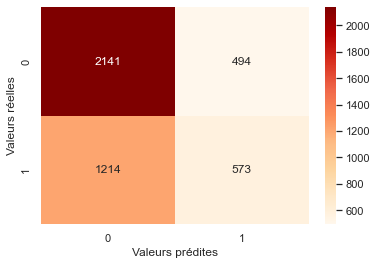

In [176]:
# Calculer la matrice de confusion
cm3 = confusion_matrix(Y_test3, Y_pred3)

# Créer la carte de chaleur
sns.heatmap(cm3, annot=True, cmap="OrRd", fmt='g')

# Ajouter les labels des axes
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Afficher la carte de chaleur
plt.show()

Nous ne constatons pas une dégradation du modèle. Il semble similaire au précédent. Nous pouvons donc conclure que Division_3 et Division_6 à Division_9 n'ont aucune influence sur le modèle. En résumé, encore une fois le modèle SVC semble avoir une précision modérée, mais il y a encore une marge d'amélioration en termes de performances globales.

## Modèle 4

In [177]:
colonne2 = ['Participant', 'Activite', 'Division_1', 'Division_2', 'Division_4', 'Division_5', 'temporalite']

data4 = data_bis.loc[:, colonne2].copy()

msk = np.random.rand(len(data4)) < 0.8

train4 = data4[msk]
test4 = data4[~msk]
X_train4 = train4.drop("temporalite", axis=1)
Y_train4 = train4["temporalite"]
X_test4 = test4.drop("temporalite", axis=1)
Y_test4 = test4["temporalite"]

data4.head()

Participant  Activite  Division_1  Division_2  Division_4  Division_5  \
0            1         4         1.0         0.0         0.0         0.0   
1            1         4         1.0         0.0         0.0         0.0   
2            1         4         1.0         0.0         0.0         0.0   
3            1         4         1.0         0.0         0.0         0.0   
4            1         4         1.0         0.0         0.0         0.0   

   temporalite  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [178]:

# Créer le modèle SVC et l'entraîner sur l'ensemble d'entraînement
svc4 = sklearn.svm.SVC()
svc4.fit(X_train4, Y_train4)

# Prédire les étiquettes sur l'ensemble de test
Y_pred4 = svc4.predict(X_test4)

# Évaluer le modèle sur l'ensemble de test
score4 = svc4.score(X_test4, Y_test4)
print("Score du modèle SVC : {:.2f}".format(score4))


Score du modèle SVC : 0.78


In [179]:
# Calculer le score F1
f1 = f1_score(Y_test4, Y_pred4)

print("Score F1 du modèle SVC : {:.2f}".format(f1))

Score F1 du modèle SVC : 0.67


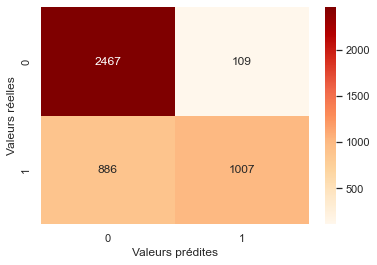

In [180]:
# Calculer la matrice de confusion
cm4 = confusion_matrix(Y_test4, Y_pred4)

# Créer la carte de chaleur
sns.heatmap(cm4, annot=True, cmap="OrRd", fmt='g')

# Ajouter les labels des axes
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Afficher la carte de chaleur
plt.show()


Le modèle SVC a obtenu un score d'environ 0.70-0.80, ce qui indique une précision relativement élevée dans la classification des données. Cela signifie que le modèle a réussi à classer correctement environ 70-80 % des échantillons.

Le score F1 du modèle SVC est d'environ 0.60-0.70. Ce score F1 suggère une performance globalement solide du modèle, où l'équilibre entre la précision et le rappel est assez bon.

Le modèle semble avoir une précision élevée et des performances globales solides.

Ce modèle nous semble le meilleur. 

## Autres modèles de test

### 1

In [201]:
colonne3 = ['Participant', 'Activite', 'Division_1', 'Division_2', 'Division_4', 'Division_5', 'temporalite', 'Duration']

data5 = data_bis.loc[:, colonne3].copy()

msk = np.random.rand(len(data5)) < 0.8

train5 = data5[msk]
test5 = data5[~msk]
X_train5 = train5.drop("temporalite", axis=1)
Y_train5 = train5["temporalite"]
X_test5 = test5.drop("temporalite", axis=1)
Y_test5 = test5["temporalite"]


# Créer le modèle SVC et l'entraîner sur l'ensemble d'entraînement
svc5 = sklearn.svm.SVC()
svc5.fit(X_train5, Y_train5)

# Prédire les étiquettes sur l'ensemble de test
Y_pred5 = svc5.predict(X_test5)

# Évaluer le modèle sur l'ensemble de test
score5 = svc5.score(X_test5, Y_test5)
print("Score du modèle SVC : {:.2f}".format(score5))

# Calculer le score F1
f1 = f1_score(Y_test5, Y_pred5)

print("Score F1 du modèle SVC : {:.2f}".format(f1))

Score du modèle SVC : 0.59
Score F1 du modèle SVC : 0.12


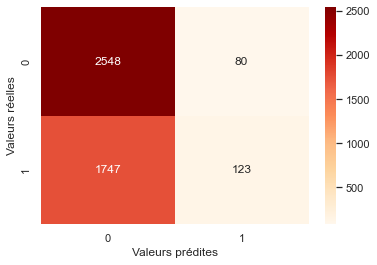

In [202]:
# Calculer la matrice de confusion
cm5 = confusion_matrix(Y_test5, Y_pred5)

# Créer la carte de chaleur
sns.heatmap(cm5, annot=True, cmap="OrRd", fmt='g')

# Ajouter les labels des axes
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Afficher la carte de chaleur
plt.show()

### 2

In [203]:
colonne4 = ['Participant', 'Activite', 'Division_1', 'Division_2', 'Division_4', 'Division_5', 'temporalite', 'Amplitude']

data6 = data_bis.loc[:, colonne4].copy()

msk = np.random.rand(len(data6)) < 0.8

train6 = data6[msk]
test6 = data6[~msk]
X_train6 = train6.drop("temporalite", axis=1)
Y_train6 = train6["temporalite"]
X_test6 = test6.drop("temporalite", axis=1)
Y_test6 = test6["temporalite"]


# Créer le modèle SVC et l'entraîner sur l'ensemble d'entraînement
svc6 = sklearn.svm.SVC()
svc6.fit(X_train6, Y_train6)

# Prédire les étiquettes sur l'ensemble de test
Y_pred6 = svc6.predict(X_test6)

# Évaluer le modèle sur l'ensemble de test
score6 = svc6.score(X_test6, Y_test6)
print("Score du modèle SVC : {:.2f}".format(score6))

# Calculer le score F1
f1 = f1_score(Y_test6, Y_pred6)

print("Score F1 du modèle SVC : {:.2f}".format(f1))

Score du modèle SVC : 0.58
Score F1 du modèle SVC : 0.00


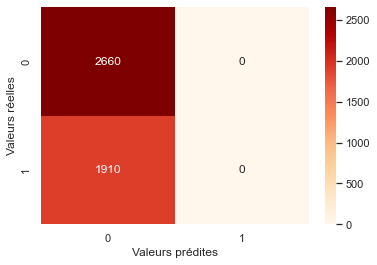

In [204]:
# Calculer la matrice de confusion
cm6 = confusion_matrix(Y_test6, Y_pred6)

# Créer la carte de chaleur
sns.heatmap(cm6, annot=True, cmap="OrRd", fmt='g')

# Ajouter les labels des axes
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Afficher la carte de chaleur
plt.show()

# Apprentissage non supervisé

# CLUSTERING

In [3]:
# Chargez les données dans un dataframe
X = pd.read_csv('df_fin_30lignes.csv')
X.head()

Participant Activite  Duration    Time   PosX   PosY  Division_1  \
0         P01   BROWSE     186.0   101.0  199.0  334.0         1.0   
1         P01   BROWSE     251.0   356.0  158.0  277.0         1.0   
2         P01   BROWSE     773.0   670.0  148.0  196.0         1.0   
3         P01   BROWSE     320.0  1510.0  295.0  191.0         1.0   
4         P01   BROWSE     638.0  1892.0  368.0  183.0         1.0   

   Division_2  Division_3  Division_4  Division_5  Division_6  Division_7  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   Division_8  Division_9    Amplitude  temporalite  
0         0.0         0.0   702.214355          0.0  
1         0.0         0.0   775.465022          0.0  
2         0.0         0.0   751.862354          0.0  
3         0.0         0.0  1273.543482          0.0  
4         0.0         0.0  1140.105697          0.0

In [4]:
# Remplacer les valeurs de "Participant" par un nombre correspondant
for i in range(1, 25):
    participant = f'P{i:02}'
    X['Participant'] = X['Participant'].replace(participant, i)

# Créer un dictionnaire de mapping pour remplacer les valeurs de la colonne "Activite" par des nombres
activite_mapping = {'WRITE':1, 'READ':2, 'WATCH':3, 'BROWSE':4, 'DEBUG':5, 'INTERPRET':6, 'PLAY':7, 'SEARCH':8}

# Remplacer les valeurs de la colonne "Activite" par les nombres correspondants
X["Activite"] = X["Activite"].replace(activite_mapping)


# Sélectionnez les colonnes qui contiennent les données d'occulométrie et les colonnes moment

data = X[['Participant', 'Activite', 'Duration',
       'Division_1', 'Division_2', 'Division_3', 'Division_4', 'Division_5',
       'Division_6', 'Division_7', 'Division_8', 'Division_9', 'Amplitude']]


datacluster = X[['Participant', 'Activite', 'Duration',
       'Division_1', 'Division_2', 'Division_3', 'Division_4', 'Division_5',
       'Division_6', 'Division_7', 'Division_8', 'Division_9', 'Amplitude']]




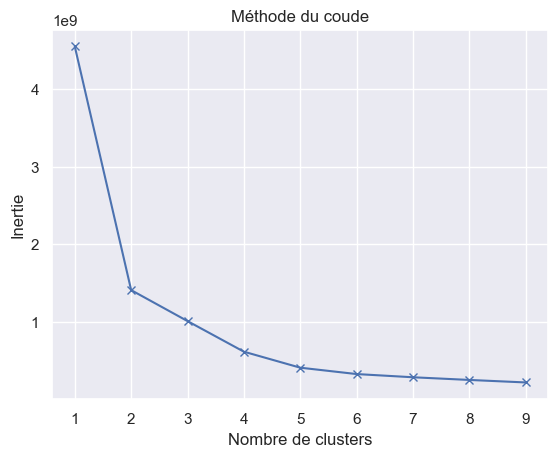

In [5]:
# Range de nombres de clusters que l'on veut tester
k_values = range(1, 10)
inertias = []

# Calculer l'inertie pour chaque valeur de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)  # Définir explicitement n_init à 10
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

# Tracer la courbe de l'inertie en fonction du nombre de clusters
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title("Méthode du coude")
plt.show()

Nous constatons que le nombre le plus optimal de cluster à former est de 2 puisque c'est la valeur qui se situe au niveau du "coude" de cette courbe. Cela est nous facilitera donc la tâche pour la suite puisque nous cherchons à prédire une variable binaire : début (0) ou fin (1).

In [6]:
# Appliquez l'algorithme K-means avec 2 clusters
kmeans = KMeans(n_clusters=2, n_init=10).fit(datacluster)
datacluster['cluster'] = kmeans.labels_
datacluster.head()

/var/folders/p8/3r2rm9j501jby2s702qkpssc0000gn/T/ipykernel_85501/3261518446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacluster['cluster'] = kmeans.labels_


Participant  Activite  Duration  Division_1  Division_2  Division_3  \
0            1         4     186.0         1.0         0.0         0.0   
1            1         4     251.0         1.0         0.0         0.0   
2            1         4     773.0         1.0         0.0         0.0   
3            1         4     320.0         1.0         0.0         0.0   
4            1         4     638.0         1.0         0.0         0.0   

   Division_4  Division_5  Division_6  Division_7  Division_8  Division_9  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

     Amplitude  cluster  
0   702.214355        0  
1   775.465022        0  
2   751.862354        0  
3  1273.543482        0  
4  1140.105697        0

In [7]:
import itertools

columns = ['Duration','Division_1', 'Division_2', 'Division_3',
           'Division_4', 'Division_5', 'Division_6', 'Division_7', 'Division_8',
           'Division_9', 'Amplitude']

column_pairs = list(itertools.combinations(columns, 2))

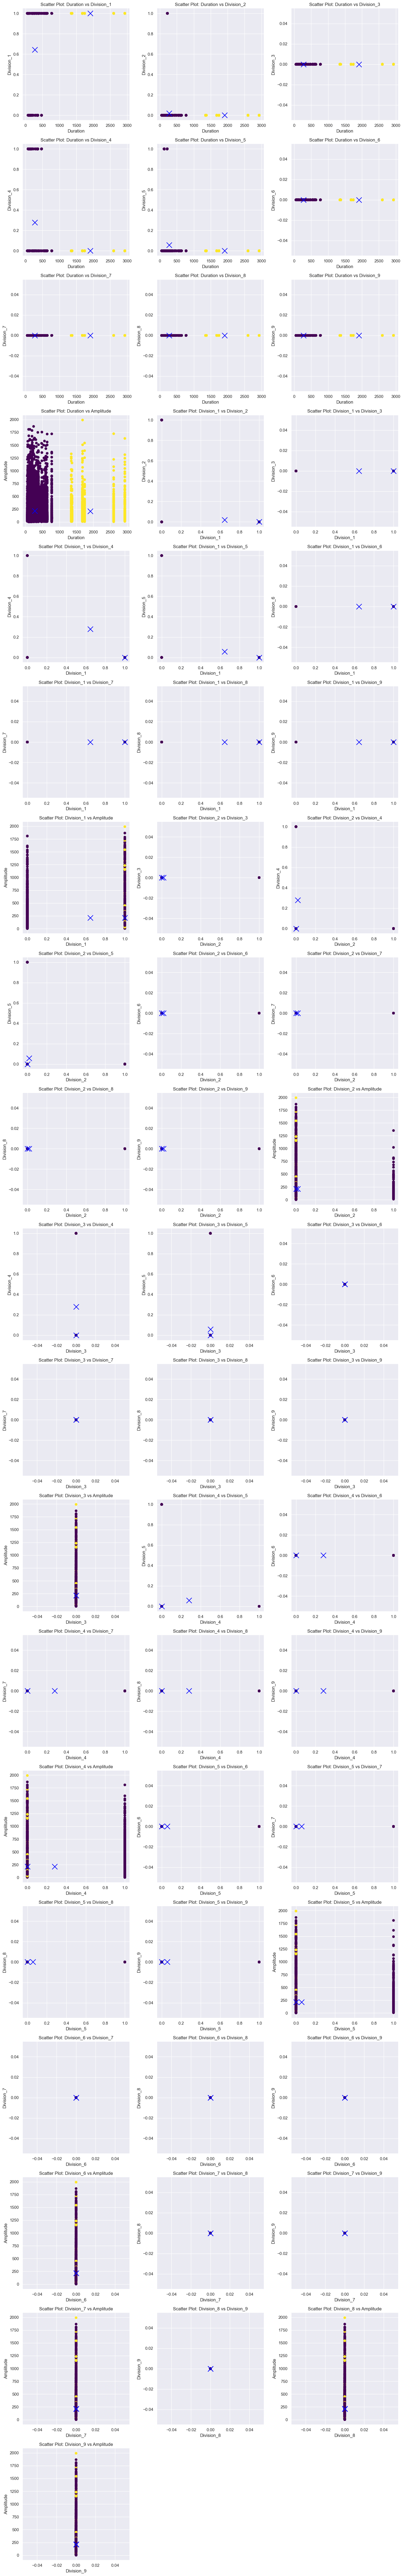

In [8]:
num_plots = len(column_pairs)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig = plt.figure(figsize=(15, 5*num_rows))

# Créer une colonne dans le DataFrame pour stocker les labels des clusters

for i, (x_col, y_col) in enumerate(column_pairs):
    row = i // num_cols
    col = i % num_cols
    
    ax = plt.subplot2grid((num_rows, num_cols), (row, col))
    
    # Scatter plot avec les points colorés selon les labels des clusters
    ax.scatter(datacluster[x_col], datacluster[y_col], c=datacluster['cluster'], cmap='viridis')
    
    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:, datacluster.columns.get_loc(x_col)], centroids[:, datacluster.columns.get_loc(y_col)],
               c='blue', marker='x', s=200)
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"Scatter Plot: {x_col} vs {y_col}")

fig.tight_layout()

plt.show()


In [9]:
from sklearn.metrics import silhouette_score

# Calculer l'indice de silhouette pour évaluer la qualité du clustering
silhouette_avg = silhouette_score(datacluster, kmeans.labels_)

# Afficher l'indice de silhouette
print("Indice de silhouette moyen:", silhouette_avg)


Indice de silhouette moyen: 0.7686567618947235


Visuellement, nous obersvons deux cluster (violet et jaune) qui semblent assez distinct l'un de l'autre. L'indice de silhouette moyen de 0.7636 nous indique d'ailleurs une bonne séparation et une cohésion des clusters. L'indice de silhouette mesure la qualité globale du clustering en évaluant à la fois la proximité des points à l'intérieur de chaque cluster et la séparation entre les clusters.

Afin de savoir sur les cluster qui ont été formés correspondent effectivement à des temporalités d'acivités, **nous allons essayer par la suite de classifier nos clusters pour comprendre ce qu'ils représentent :**



In [10]:
# merge avec X pour avoir de nouveau la variable temporalite
merged_data = X[['Participant', 'Activite', 'temporalite','Duration','Amplitude']].join(datacluster.set_index(['Participant', 'Activite','Duration','Amplitude']), on=['Participant', 'Activite','Duration','Amplitude'])
merged_data.head(20)

Participant  Activite  temporalite  Duration    Amplitude  Division_1  \
0             1         4          0.0     186.0   702.214355         1.0   
1             1         4          0.0     251.0   775.465022         1.0   
2             1         4          0.0     773.0   751.862354         1.0   
3             1         4          0.0     320.0  1273.543482         1.0   
4             1         4          0.0     638.0  1140.105697         1.0   
5             1         4          0.0     383.0   211.740407         1.0   
6             1         4          0.0     200.0   253.570503         1.0   
7             1         4          0.0     592.0   245.617589         1.0   
8             1         4          0.0     191.0    87.641314         1.0   
9             1         4          0.0     193.0   108.503456         1.0   
10            1         4          0.0     246.0   152.689227         1.0   
11            1         4          0.0     374.0   106.470653         1.0   
12            1         4          0.0     131.0  1054.017078         1.0   
13            1         4          0.0    2930.0   166.075284         1.0   
14            1         4          0.0    1683.0   852.094478         1.0   
15            1         4          0.0     600.0   827.241198         1.0   
16            1         4          0.0     129.0   733.753365         1.0   
17            1         4          0.0      63.0   430.846841         1.0   
18            1         4          0.0      96.0   245.934951         1.0   
19            1         4          0.0      66.0   125.195847         1.0   

    Division_2  Division_3  Division_4  Division_5  Division_6  Division_7  \
0          0.0         0.0         0.0         0.0         0.0         0.0   
1          0.0         0.0         0.0         0.0         0.0         0.0   
2          0.0         0.0         0.0         0.0         0.0         0.0   
3          0.0         0.0         0.0         0.0         0.0         0.0   
4          0.0         0.0         0.0         0.0         0.0         0.0   
5          0.0         0.0         0.0         0.0         0.0         0.0   
6          0.0         0.0         0.0         0.0         0.0         0.0   
7          0.0         0.0         0.0         0.0         0.0         0.0   
8          0.0         0.0         0.0         0.0         0.0         0.0   
9          0.0         0.0         0.0         0.0         0.0         0.0   
10         0.0         0.0         0.0         0.0         0.0         0.0   
11         0.0         0.0         0.0         0.0         0.0         0.0   
12         0.0         0.0         0.0         0.0         0.0         0.0   
13         0.0         0.0         0.0         0.0         0.0         0.0   
14         0.0         0.0         0.0         0.0         0.0         0.0   
15         0.0         0.0         0.0         0.0         0.0         0.0   
16         0.0         0.0         0.0         0.0         0.0         0.0   
17         0.0         0.0         0.0         0.0         0.0         0.0   
18         0.0         0.0         0.0         0.0         0.0         0.0   
19         0.0         0.0         0.0         0.0         0.0         0.0   

    Division_8  Division_9  cluster  
0          0.0         0.0        0  
1          0.0         0.0        0  
2          0.0         0.0        0  
3          0.0         0.0        0  
4          0.0         0.0        0  
5          0.0         0.0        0  
6          0.0         0.0        0  
7          0.0         0.0        0  
8          0.0         0.0        0  
9          0.0         0.0        0  
10         0.0         0.0        0  
11         0.0         0.0        0  
12         0.0         0.0        0  
13         0.0         0.0        1  
14         0.0         0.0        1  
15         0.0         0.0        0  
16         0.0         0.0        0  
17         0.0         0.0        0  
18         0.0         0.

In [214]:
merged_data.shape

(11212, 15)

In [11]:
zero_count = merged_data[merged_data['cluster'] == 0]['temporalite'].value_counts()
one_count = merged_data[merged_data['cluster'] == 1]['temporalite'].value_counts()

print("Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 0:")
print(zero_count)

print("Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 1:")
print(one_count)


Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 0:
1.0    5033
0.0    4992
Name: temporalite, dtype: int64
Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 1:
0.0    768
1.0    561
Name: temporalite, dtype: int64


Nous pourrions donc suggérer ici que le cluster n'est pas du tout performant car il est assez compliqué de définir si les labels pourraient correspondre à la temporalité. 

In [261]:
# Supposons que cluster 0 correspond à temporalité 0
# Supposons que cluster_pred soit la valeur prédite pour la colonne 'cluster' et temporalite_true soit la valeur réelle pour la colonne 'temporalite'
cluster_pred = merged_data['cluster']
temporalite_true = merged_data['temporalite']

# Calcul de l'accuracy score
accuracy = accuracy_score(temporalite_true, cluster_pred)

print("Accuracy Score:", accuracy)

Accuracy Score: 0.5493812298357972


In [263]:
# Supposons que cluster 1 correspond à temporalité 0
# Créer un dictionnaire de mapping pour remplacer les valeurs 
mapping = {0:1, 1:0}

# Remplacer les valeurs de la colonne "cluster" par les nombres correspondants
merged_data["cluster"] = merged_data["cluster"].replace(mapping)

# Supposons que cluster_pred soit la valeur prédite pour la colonne 'cluster' et temporalite_true soit la valeur réelle pour la colonne 'temporalite'
cluster_pred = merged_data['cluster']
temporalite_true = merged_data['temporalite']

# Calcul de l'accuracy score
accuracy = accuracy_score(temporalite_true, cluster_pred)

print("Accuracy Score:", accuracy)

Accuracy Score: 0.4506187701642028


In [264]:
from sklearn.metrics import adjusted_rand_score

true_labels = merged_data['temporalite']  # Récupérer les vrais labels
cluster_labels = merged_data['cluster']  # Récupérer les labels des clusters

ari = adjusted_rand_score(true_labels, cluster_labels)
print("Indice de Rand:", ari)

Indice de Rand: -0.014230755446449193


Notre indice de Rand très peu élevé suggère d'ailleurs que nos clusters ne semblent pas particulièrement bien correspondre aux temporalités d'une activité.

In [ ]:
#A PARTIR DE LA J AI PAS TROP COMPRIS ON FAIT QUOI 

Nous réessayons de faire du clustering en ne retenant uniquement les variables les plus pertinentes. 

In [12]:
# Sélectionnez les colonnes qui contiennent les données d'occulométrie et les colonnes moment
datacluster2 = X[['Participant', 'Activite',
       'Division_1', 'Division_2', 'Division_4', 'Division_5']]

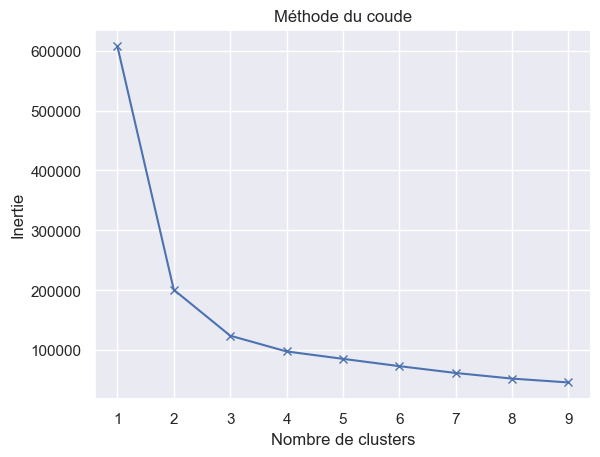

In [13]:
# Range de nombres de clusters que vous voulez tester
k_values = range(1, 10)
inertias = []

# Calculer l'inertie pour chaque valeur de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)  # Définir explicitement n_init à 10
    kmeans.fit(datacluster2)
    inertias.append(kmeans.inertia_)

# Tracer la courbe de l'inertie en fonction du nombre de clusters
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title("Méthode du coude")
plt.show()

Là encore, 2 est le nombre de cluster le plus optimal que nous pouvons former.

In [14]:

# Appliquez l'algorithme K-means avec 2 clusters
kmeans = KMeans(n_clusters=2).fit(datacluster2)
datacluster2['cluster'] = kmeans.labels_
# merge avec X pour avoir de nouveau la variable temporalite
merged_data2 = X[['Participant', 'Activite', 'temporalite','Duration','Amplitude']].join(datacluster.set_index(['Participant', 'Activite','Duration','Amplitude']), on=['Participant', 'Activite','Duration','Amplitude'])
merged_data2.head()


/var/folders/p8/3r2rm9j501jby2s702qkpssc0000gn/T/ipykernel_85501/2325652103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacluster2['cluster'] = kmeans.labels_


Participant  Activite  temporalite  Duration    Amplitude  Division_1  \
0            1         4          0.0     186.0   702.214355         1.0   
1            1         4          0.0     251.0   775.465022         1.0   
2            1         4          0.0     773.0   751.862354         1.0   
3            1         4          0.0     320.0  1273.543482         1.0   
4            1         4          0.0     638.0  1140.105697         1.0   

   Division_2  Division_3  Division_4  Division_5  Division_6  Division_7  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   Division_8  Division_9  cluster  
0         0.0         0.0        0  
1         0.0         0.0        0  
2         0.0         0.0        0  
3         0.0         0.0        0  
4         0.0         0.0        0

In [15]:
zero_count = merged_data2[merged_data2['cluster'] == 0]['temporalite'].value_counts()
one_count = merged_data2[merged_data2['cluster'] == 1]['temporalite'].value_counts()

print("Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 0:")
print(zero_count)

print("Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 1:")
print(one_count)


Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 0:
1.0    5033
0.0    4992
Name: temporalite, dtype: int64
Occurrences de valeurs de 'temporalite' lorsque 'cluster' est égal à 1:
0.0    768
1.0    561
Name: temporalite, dtype: int64


In [271]:
true_labels = merged_data2['temporalite']  # Récupérer les vrais labels
cluster_labels = merged_data2['cluster']  # Récupérer les labels des clusters

ari = adjusted_rand_score(true_labels, cluster_labels)
print("Indice de Rand:", ari)

Indice de Rand: -0.014230755446449193


In [304]:
# Vérifier les valeurs uniques et leur fréquence pour la colonne "cluster"
print("Valeurs et fréquences pour la colonne 'cluster':")
print(merged_data2['cluster'].value_counts())

# Vérifier les valeurs uniques et leur fréquence pour la colonne "Division"
print("Valeurs et fréquences pour la colonne 'Division':")
print(merged_data2['Division_1'].value_counts())

# Vérifier les valeurs uniques et leur fréquence pour la colonne "Division"
print("Valeurs et fréquences pour la colonne 'Division':")
print(merged_data2['Division_2'].value_counts())

# Vérifier les valeurs uniques et leur fréquence pour la colonne "Division"
print("Valeurs et fréquences pour la colonne 'Division':")
print(merged_data2['Division_3'].value_counts())

# Vérifier les valeurs uniques et leur fréquence pour la colonne "Division"
print("Valeurs et fréquences pour la colonne 'Division':")
print(merged_data2['Division_4'].value_counts())

# Vérifier les valeurs uniques et leur fréquence pour la colonne "Division"
print("Valeurs et fréquences pour la colonne 'Division':")
print(merged_data2['Division_5'].value_counts())


Valeurs et fréquences pour la colonne 'cluster':
0    37340
1     4194
Name: cluster, dtype: int64
Valeurs et fréquences pour la colonne 'Division':
1.0    27455
0.0    14079
Name: Division_1, dtype: int64
Valeurs et fréquences pour la colonne 'Division':
0.0    40766
1.0      768
Name: Division_2, dtype: int64
Valeurs et fréquences pour la colonne 'Division':
0.0    41534
Name: Division_3, dtype: int64
Valeurs et fréquences pour la colonne 'Division':
0.0    30719
1.0    10815
Name: Division_4, dtype: int64
Valeurs et fréquences pour la colonne 'Division':
0.0    39038
1.0     2496
Name: Division_5, dtype: int64


In [305]:
true_labels = merged_data2['Division_4']  # Récupérer les vrais labels
cluster_labels = merged_data2['cluster']  # Récupérer les labels des clusters

ari = adjusted_rand_score(true_labels, cluster_labels)
print("Indice de Rand:", ari)

Indice de Rand: -0.08127914731317781


In [307]:
true_labels = merged_data2['Division_1']  # Récupérer les vrais labels
cluster_labels = merged_data2['cluster']  # Récupérer les labels des clusters

ari = adjusted_rand_score(true_labels, cluster_labels)
print("Indice de Rand:", ari)

Indice de Rand: -0.055291963495106955


***Conclusion :*** 


Pour la classification, dans l'ensemble, le modèle SVC semble avoir une précision globale raisonnablement élevée, mais il peut encore etre amélioré. Il serait également interessant de tester avec d'autres features.

Nous pouvons conclure de la partie classification que les points de fixations semblent être assez différents en début et d'activités, ce qui laisse suggérer une exploration différente des pages en fonction du début et de la fin de l'activité, des activités et des personnes. Le modèle avec juste la Duration et l'Amplitude ne nous semble pas si performant, c'est également le cas pour le Modèle 4 auquel on a ajouté Duration ou auquel on a ajouté Amplitude. 

Nous pensons donc qu'au final les durées de fixation et d'amplitude ne semblent pas rééllement influencer la prédiction du début ou de fin d'activités, ce qui peut laisser croire que ces données ne réflentent pas vraiment la concentration du début d'activité lors de l'exploration du début d'activité.